# TIF360 Project

Main source: https://www.kaggle.com/code/rmonge/predicting-molecule-properties-based-on-its-smiles/notebook

### Import packages

In [72]:
import os
import rdkit
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
import torch.nn.functional as F

from sklearn.metrics import r2_score

### Load data

In [73]:
df = pd.read_csv("../data/smiles_and_targets.csv")
print(np.shape(df))

### Load descriptors

In [74]:
mol_descriptor = np.load("../data/mol_descriptors.npy")
print(np.shape(mol_descriptor))

### Load Morgan fingerprints

In [75]:
mol_fingerprints = np.load("../data/mol_morgan_fingerprints.npy")
print(np.shape(mol_fingerprints))

# Investigate Neural Networks

## Graph Neural Networks

#### Convert data to graphs

In [76]:
# import packages
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

We use the above functions to create a dataset of molecular graphs from the smiles and labels corresponding to chemical properties

In [98]:
from graph_dataset_functions import create_graph_dataset_from_smiles

properties_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']

x_smiles = df.smiles.values
y = df.loc[:, properties_names].values  # shape = (n_samples, n_properties)

dataset = create_graph_dataset_from_smiles(x_smiles, y[0:len(x_smiles), :])

Information of the graph dataset

In [99]:
print(f'Number of graphs (molecules): {len(dataset)}')
graph = dataset[50]
print('=================================================================================')
print(f'Properties of graph 50')
print('molecule smiles: {df.smiles.values[50]}')
print(f'Number of nodes: {dataset[50].x.shape[0]}')
print(f'Number of edges: {dataset[50].edge_index.shape[1]}')
print(f'Number of node features: {dataset[50].x.shape[1]}')
print(f'Number of edge features: {dataset[50].edge_attr.shape[1]}')
print(f'Number of properties: {dataset[50].y.shape[1]}')

Number of graphs (molecules): 132820
Properties of graph 50
molecule smiles: {df.smiles.values[50]}
Number of nodes: 6
Number of edges: 12
Number of node features: 81
Number of edge features: 10
Number of properties: 15


Filterout data with no edge features defined (Like ex: CH4) (These causes problems down the line)

In [100]:
indexes_to_delete = []
for item in range(0,len(dataset)):
    if dataset[item].edge_attr.shape[1] == 0:
        indexes_to_delete.append(item)
    else:
        pass

indexes_to_delete.sort()

print("Number of none edge feature molecules: ", len(indexes_to_delete))

print("Before: ", len(dataset))

for item in range(0,len(indexes_to_delete)):
    print("Molecule to delete: ", df.smiles.values[indexes_to_delete[item]])
    #del dataset[indexes_to_delete[item] - item] 
    dataset.pop((indexes_to_delete[item] - item)) # -item since all future data points will have its index reduced by 1 for each deleted previous data point
print("After: ", len(dataset))

Number of none edge feature molecules:  0
Before:  132820
After:  132820


Split data into train and test set

In [101]:
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# split the dataset into test and validation:
num_samples = len(dataset)

# Want to divide data randomly
random.seed(42)
random_indexes = np.array(random.sample(range(num_samples), num_samples)) # random.sample ensures no duplicates

train_data = [dataset[index] for index in random_indexes[int(.2 * num_samples ) :]] # 80%
test_data = [dataset[index] for index in random_indexes[: int(.2 * num_samples )]] # 20%

print("Example train data target vector before scaling:")
print(train_data[0].y.numpy())

Example train data target vector before scaling:
[[ 2.9692900e+00  1.9776900e+00  1.8422800e+00  1.2093000e+00
   8.4059998e+01 -1.8970001e-01 -7.0400000e-02  1.1930000e-01
   8.7338800e+02  1.5987501e-01 -3.4861154e+02 -3.4860477e+02
  -3.4860382e+02 -3.4864203e+02  2.9188999e+01]]


Normalize numerical node features

In [102]:
train_data_features = torch.cat([data.x for data in train_data], axis=0)
test_data_features = torch.cat([data.x for data in test_data], axis=0)

print("Feature matrix shape:", train_data_features.numpy().shape)
print("Example train data features before scaling:")
print(train_data_features[0].numpy())
print("The final 3 features are the numerical ones to be scaled")
print(train_data_features[0][-3:].numpy())

train_data_num_features = train_data_features[:, -3:].numpy()
test_data_num_features = test_data_features[:, -3:].numpy()

df_train_data_num_features = pd.DataFrame(train_data_num_features)
df_train_data_num_features.columns = ['atomic_mass', 'VDW_radius', 'covalent_radius']

Feature matrix shape: (935599, 81)
Example train data features before scaling:
[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     1.     0.     0.     0.     0.     0.
  0.     0.     1.     0.     0.     0.     0.     0.     0.     0.
  1.     0.     0.     0.     1.     0.     1.     0.     1.     0.
  0.     0.     0.     0.     0.     1.     0.     0.    12.011  1.7
  0.68 ]
The final 3 features are the numerical ones to be scaled
[12.011  1.7    0.68 ]


In [103]:
df_train_data_num_features.describe()

,atomic_mass,VDW_radius,covalent_radius
count,935599.000000,935599.000000,935599.000000
mean,12.902596,1.663674,0.679892
std,1.531384,0.059687,0.002076
min,12.011000,1.500000,0.640000
25%,12.011000,1.600000,0.680000
50%,12.011000,1.700000,0.680000
75%,14.007000,1.700000,0.680000
max,18.997999,1.700000,0.680000


In [104]:
df_train_data_num_features.value_counts()

atomic_mass  VDW_radius  covalent_radius
12.011000    1.70        0.68               672830
15.999000    1.55        0.68               149136
14.007000    1.60        0.68               111107
18.997999    1.50        0.64                 2526
dtype: int64

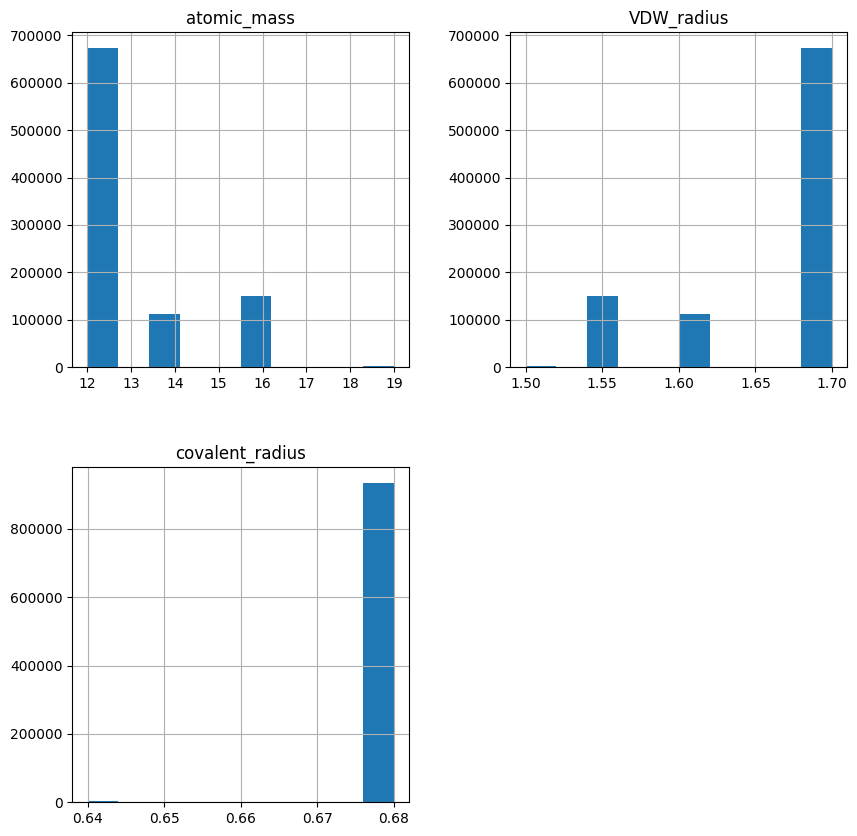

In [105]:
hist = df_train_data_num_features.hist(bins=10, figsize=(10,10))
plt.ylim(0, 1000)
plt.show()

Normalize target vectors

In [106]:
train_data_targets = torch.cat([data.y for data in train_data], axis=0)
test_data_targets = torch.cat([data.y for data in test_data], axis=0)

scaler = StandardScaler()
train_data_targets = scaler.fit_transform(train_data_targets)
test_data_targets = scaler.transform(test_data_targets)

# print("Example train data target", train_data_targets[0].reshape(1,-1).shape)
train_data_targets = torch.tensor(train_data_targets, dtype=torch.float)
test_data_targets = torch.tensor(test_data_targets, dtype=torch.float)

train_data = [Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, y=train_data_targets[index].reshape(1,-1)) for index, data in enumerate(train_data)]
test_data = [Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, y=test_data_targets[index].reshape(1,-1)) for index, data in enumerate(test_data)]
print("Example train data target after scaling:")
print(train_data[0].y.numpy())

print("Total data size: ", len(dataset))
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

Example train data target after scaling:
[[-0.33502066  1.3299793   2.2841105  -1.0263553   1.0990419   2.2975376
  -1.7445427  -2.7966008  -1.1526545   0.33569613  1.6154975   1.6154622
   1.6154623   1.6155523  -0.606702  ]]
Total data size:  132820
Train data size:  106256
Test data size:  26564


Scale molecular descriptors

In [149]:
mol_descriptor = np.load("../data/mol_descriptors.npy")
mol_fingerprints = np.load("../data/mol_morgan_fingerprints.npy")

In [150]:
df_mol_descriptors = pd.DataFrame(mol_descriptor)
print("Shape of mol_descriptors:", np.shape(df_mol_descriptors))
df_mol_descriptors.describe()

Shape of mol_descriptors: (132820, 209)


,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
count,1.328200e+05,1.328200e+05,132820.000000,132820.000000,1.328200e+05,1.328200e+05,1.328200e+05,1.328200e+05,132820.0,132820.0,...,132820.0,132820.0,132820.0,132820.0,132820.0,132820.0,132820.0,132820.0,132820.0,132820.0
mean,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,9.205300e+01,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.776364e-15,1.776364e-15,0.000000,0.000000,2.220454e-16,2.842182e-14,2.842182e-14,4.263272e-14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,9.205300e+01,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,9.205300e+01,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,9.205300e+01,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,9.205300e+01,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,9.205300e+01,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Remove non-informative molecular descriptors

In [ ]:
df_mol_descriptors

Divide descriptors and fingerprints into train and test

In [129]:
train_data_descriptor = [mol_descriptor[index,:] for index in random_indexes[int(.2 * num_samples ) :]] # 80%
test_data_desriptors = [mol_descriptor[index,:] for index in random_indexes[: int(.2 * num_samples )]] # 20%

train_data_fingerprints = [mol_fingerprints[index,:] for index in random_indexes[int(.2 * num_samples ) :]] # 80%
test_data_fingerprints = [mol_fingerprints[index,:] for index in random_indexes[: int(.2 * num_samples )]] # 20%

Normalize using MinMax

In [120]:
minmax_scaler = MinMaxScaler()

train_data_descriptor = minmax_scaler.fit_transform(train_data_descriptor)

test_data_desriptors = minmax_scaler.transform(test_data_desriptors)

In [160]:
# find all columns with all same values
df_scaled = pd.DataFrame(train_data_descriptor)
print(unique_vals.shape)
print("Number of unique values in each column:")
print(np.min(unique_vals))
df_scaled.describe()
# print("Number of columns with all same values: ", len(zero_cols))
# df_mol_descriptors.drop(zero_cols, axis=1, inplace=True)
# print("Shape of mol_descriptors after removing non-informative descriptors:", np.shape(df_mol_descriptors))
# df_mol_descriptors.describe()

(209,)
Number of unique values in each column:
1


,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
count,1.062560e+05,1.062560e+05,106256.000000,106256.000000,1.062560e+05,1.062560e+05,106256.000,1.062560e+05,106256.0,106256.0,...,106256.0,106256.0,106256.0,106256.0,106256.0,106256.0,106256.0,106256.0,106256.0,106256.0
mean,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,92.053,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,3.552730e-15,3.552730e-15,0.000000,0.000000,2.220456e-16,2.842184e-14,0.000,2.842184e-14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,92.053,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,92.053,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,92.053,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,92.053,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.007764e+01,1.007764e+01,0.085046,0.085046,5.215844e-01,1.021330e+02,92.053,1.020681e+02,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
minmax_scaler = MinMaxScaler()

train_data_fingerprints = minmax_scaler.fit_transform(train_data_fingerprints)

test_data_fingerprints = minmax_scaler.transform(test_data_fingerprints)

Combine descriptors temporarely with in train and test data for graphs

In [122]:
#Testing stuff

temp = train_data[1000]
temp.descriptors = train_data_descriptor[1000,:]

print(temp)

Data(x=[9, 81], edge_index=[2, 20], edge_attr=[20, 10], y=[1, 15], descriptors=[209], fingerprints=[1, 2048])


In [123]:

for index in range(0,len(train_data)):
    train_data[index].descriptors = torch.FloatTensor([train_data_descriptor[index,:]])
    train_data[index].fingerprints = torch.FloatTensor([train_data_fingerprints[index,:]])

for index in range(0,len(test_data)):
    test_data[index].descriptors = torch.FloatTensor([test_data_desriptors[index,:]])
    test_data[index].fingerprints = torch.FloatTensor([test_data_fingerprints[index,:]])

# Example
print(train_data[0])

KeyboardInterrupt: 

Use dataloader

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)